<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Classification with Python</font></h1>


In this notebook we try to practice all the classification algorithms that we have learned in this course.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import matplotlib.ticker as ticker
%matplotlib inline

from sklearn import preprocessing
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-12-15 15:04:50--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22,56K  55,2KB/s    in 0,4s    

2021-12-15 15:04:53 (55,2 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

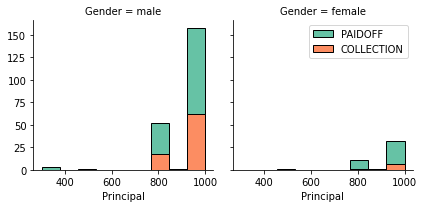

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

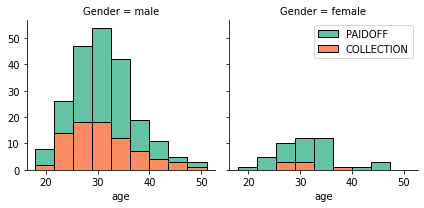

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


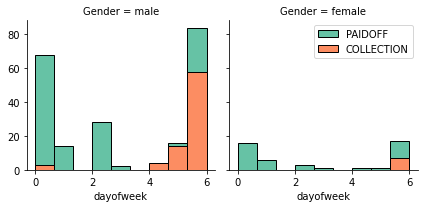

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [11]:
df['dayofweek']

0      3
1      3
2      3
3      4
4      4
      ..
341    6
342    6
343    0
344    0
345    0
Name: dayofweek, Length: 346, dtype: int64

In [12]:
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4


In [13]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [14]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [15]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [16]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [17]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to convert categorical variables to binary variables and append them to the feature Data Frame


In [18]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [19]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our labels?


In [20]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [21]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# My project starts here

# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


### Splitting the data into train and test sets

In [22]:
from sklearn.model_selection import train_test_split
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X, y, test_size=0.20, random_state=4)
print ('Train set:', X_train_knn.shape,  y_train_knn.shape)
print ('Test set:', X_test_knn.shape,  y_test_knn.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


### Importing k-nearest neighbor library, and testing for a specific value of K

In [23]:

k_sp = 2
neigh_sp = KNeighborsClassifier(n_neighbors = k_sp).fit(X_train_knn,y_train_knn)
##neigh
yhat_sp = neigh_sp.predict(X_test_knn)

### Importing library and calculating the accuracy for the specific value of K (called k_sp)

In [24]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train_knn, neigh_sp.predict(X_train_knn)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test_knn, yhat_sp))

Train set Accuracy:  0.822463768115942
Test set Accuracy:  0.6571428571428571


### Testing for several values of K

In [25]:
Ks = 50
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):   
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train_knn,y_train_knn)
    yhat_knn=neigh.predict(X_test_knn)
    mean_acc[n-1] = metrics.accuracy_score(y_test_knn, yhat_knn)

    
    std_acc[n-1]=np.std(yhat_knn==y_test_knn)/np.sqrt(yhat_knn.shape[0])

#print(yhat_knn)
#mean_acc

### Plotting the accuracy vs K

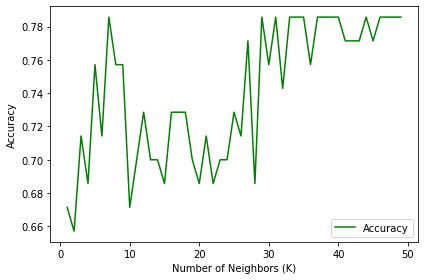

In [26]:
plt.plot(range(1,Ks),mean_acc,'g')
#plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
#plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10, color="green")
plt.legend(('Accuracy', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [27]:
print("The best accuracy was with", mean_acc.max(), "with k =", mean_acc.argmax()+1) 

The best accuracy was with 0.7857142857142857 with k = 7


In [28]:
#print(y_test_knn)

In [29]:
kk = 7
neigh2 = KNeighborsClassifier(n_neighbors = kk).fit(X_train_knn,y_train_knn)
##neigh
yhat2 = neigh2.predict(X_test_knn)



y_test_knn_bin=[]
yhat2_bin=[]

le_class = preprocessing.LabelEncoder()
le_class.fit(['COLLECTION','PAIDOFF'])
y_test_knn_bin[:] = le_class.transform(y_test_knn[:]) 
yhat2_bin[:] = le_class.transform(yhat2[:])

print(y_test_knn_bin, yhat2_bin)
#df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
#df.head()


#

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1] [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


In [30]:
jaccard_score(y_test_knn_bin, yhat2_bin, average='binary')

0.765625

In [31]:
f1_score(y_test_knn_bin, yhat2_bin, average='binary')

0.8672566371681416

# Decision Tree


### Downloading and processing the data

In [32]:
df_DT = pd.read_csv('loan_train.csv')
df_DT.head()

df_DT.drop(['Unnamed: 0.1'], axis = 1,inplace=True)
df_DT.drop(['Unnamed: 0'], axis = 1,inplace=True)
df_DT.drop(['effective_date'], axis = 1,inplace=True)
df_DT.drop(['due_date'], axis = 1,inplace=True)
df_DT.head()

df_DT=df_DT[['Principal', 'terms', 'age', 'education', 'Gender', 'loan_status']]
df_DT.head()

,Principal,terms,age,education,Gender,loan_status
0,1000,30,45,High School or Below,male,PAIDOFF
1,1000,30,33,Bechalor,female,PAIDOFF
2,1000,15,27,college,male,PAIDOFF
3,1000,30,28,college,female,PAIDOFF
4,1000,30,29,college,male,PAIDOFF


### Replacing categorical values to numerical values

In [33]:
df_DT['education'].replace(to_replace=['High School or Below','Bechalor', 'Master or Above', 'college'], value=[0,1,2,3],inplace=True)
df_DT['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)

df_DT.head()

,Principal,terms,age,education,Gender,loan_status
0,1000,30,45,0,0,PAIDOFF
1,1000,30,33,1,1,PAIDOFF
2,1000,15,27,3,0,PAIDOFF
3,1000,30,28,3,1,PAIDOFF
4,1000,30,29,3,0,PAIDOFF


### Defining x and y variables

In [34]:
X_DT = df_DT[['Principal', 'terms', 'age', 'education', 'Gender']].values

y_DT = df_DT["loan_status"]

X_DT[0:5]

#print(X_DT[0:5],y_DT[0:5])

array([[1000,   30,   45,    0,    0],
       [1000,   30,   33,    1,    1],
       [1000,   15,   27,    3,    0],
       [1000,   30,   28,    3,    1],
       [1000,   30,   29,    3,    0]])

### Splitting the data into train and test sets

In [35]:
X_train_DT, X_test_DT, y_train_DT, y_test_DT = train_test_split(X_DT, y_DT, test_size=0.25, random_state=3)

print(X_train_DT.shape,y_train_DT.shape,X_test_DT.shape,y_test_DT.shape)

(259, 5) (259,) (87, 5) (87,)


### Modeling. The decision tree will be based in the entropy criteria

In [36]:
loanTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
#drugTree # it shows the default parameter
loanTree.fit(X_train_DT,y_train_DT)

DecisionTreeClassifier(criterion='entropy', max_depth=4)

### Prediction

In [37]:
predTree = loanTree.predict(X_test_DT)
predTree

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 

### Evaluation

In [38]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test_DT, predTree))

DecisionTrees's Accuracy:  0.735632183908046


### Decision Tree Visualization

In [39]:
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

In [40]:
from io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

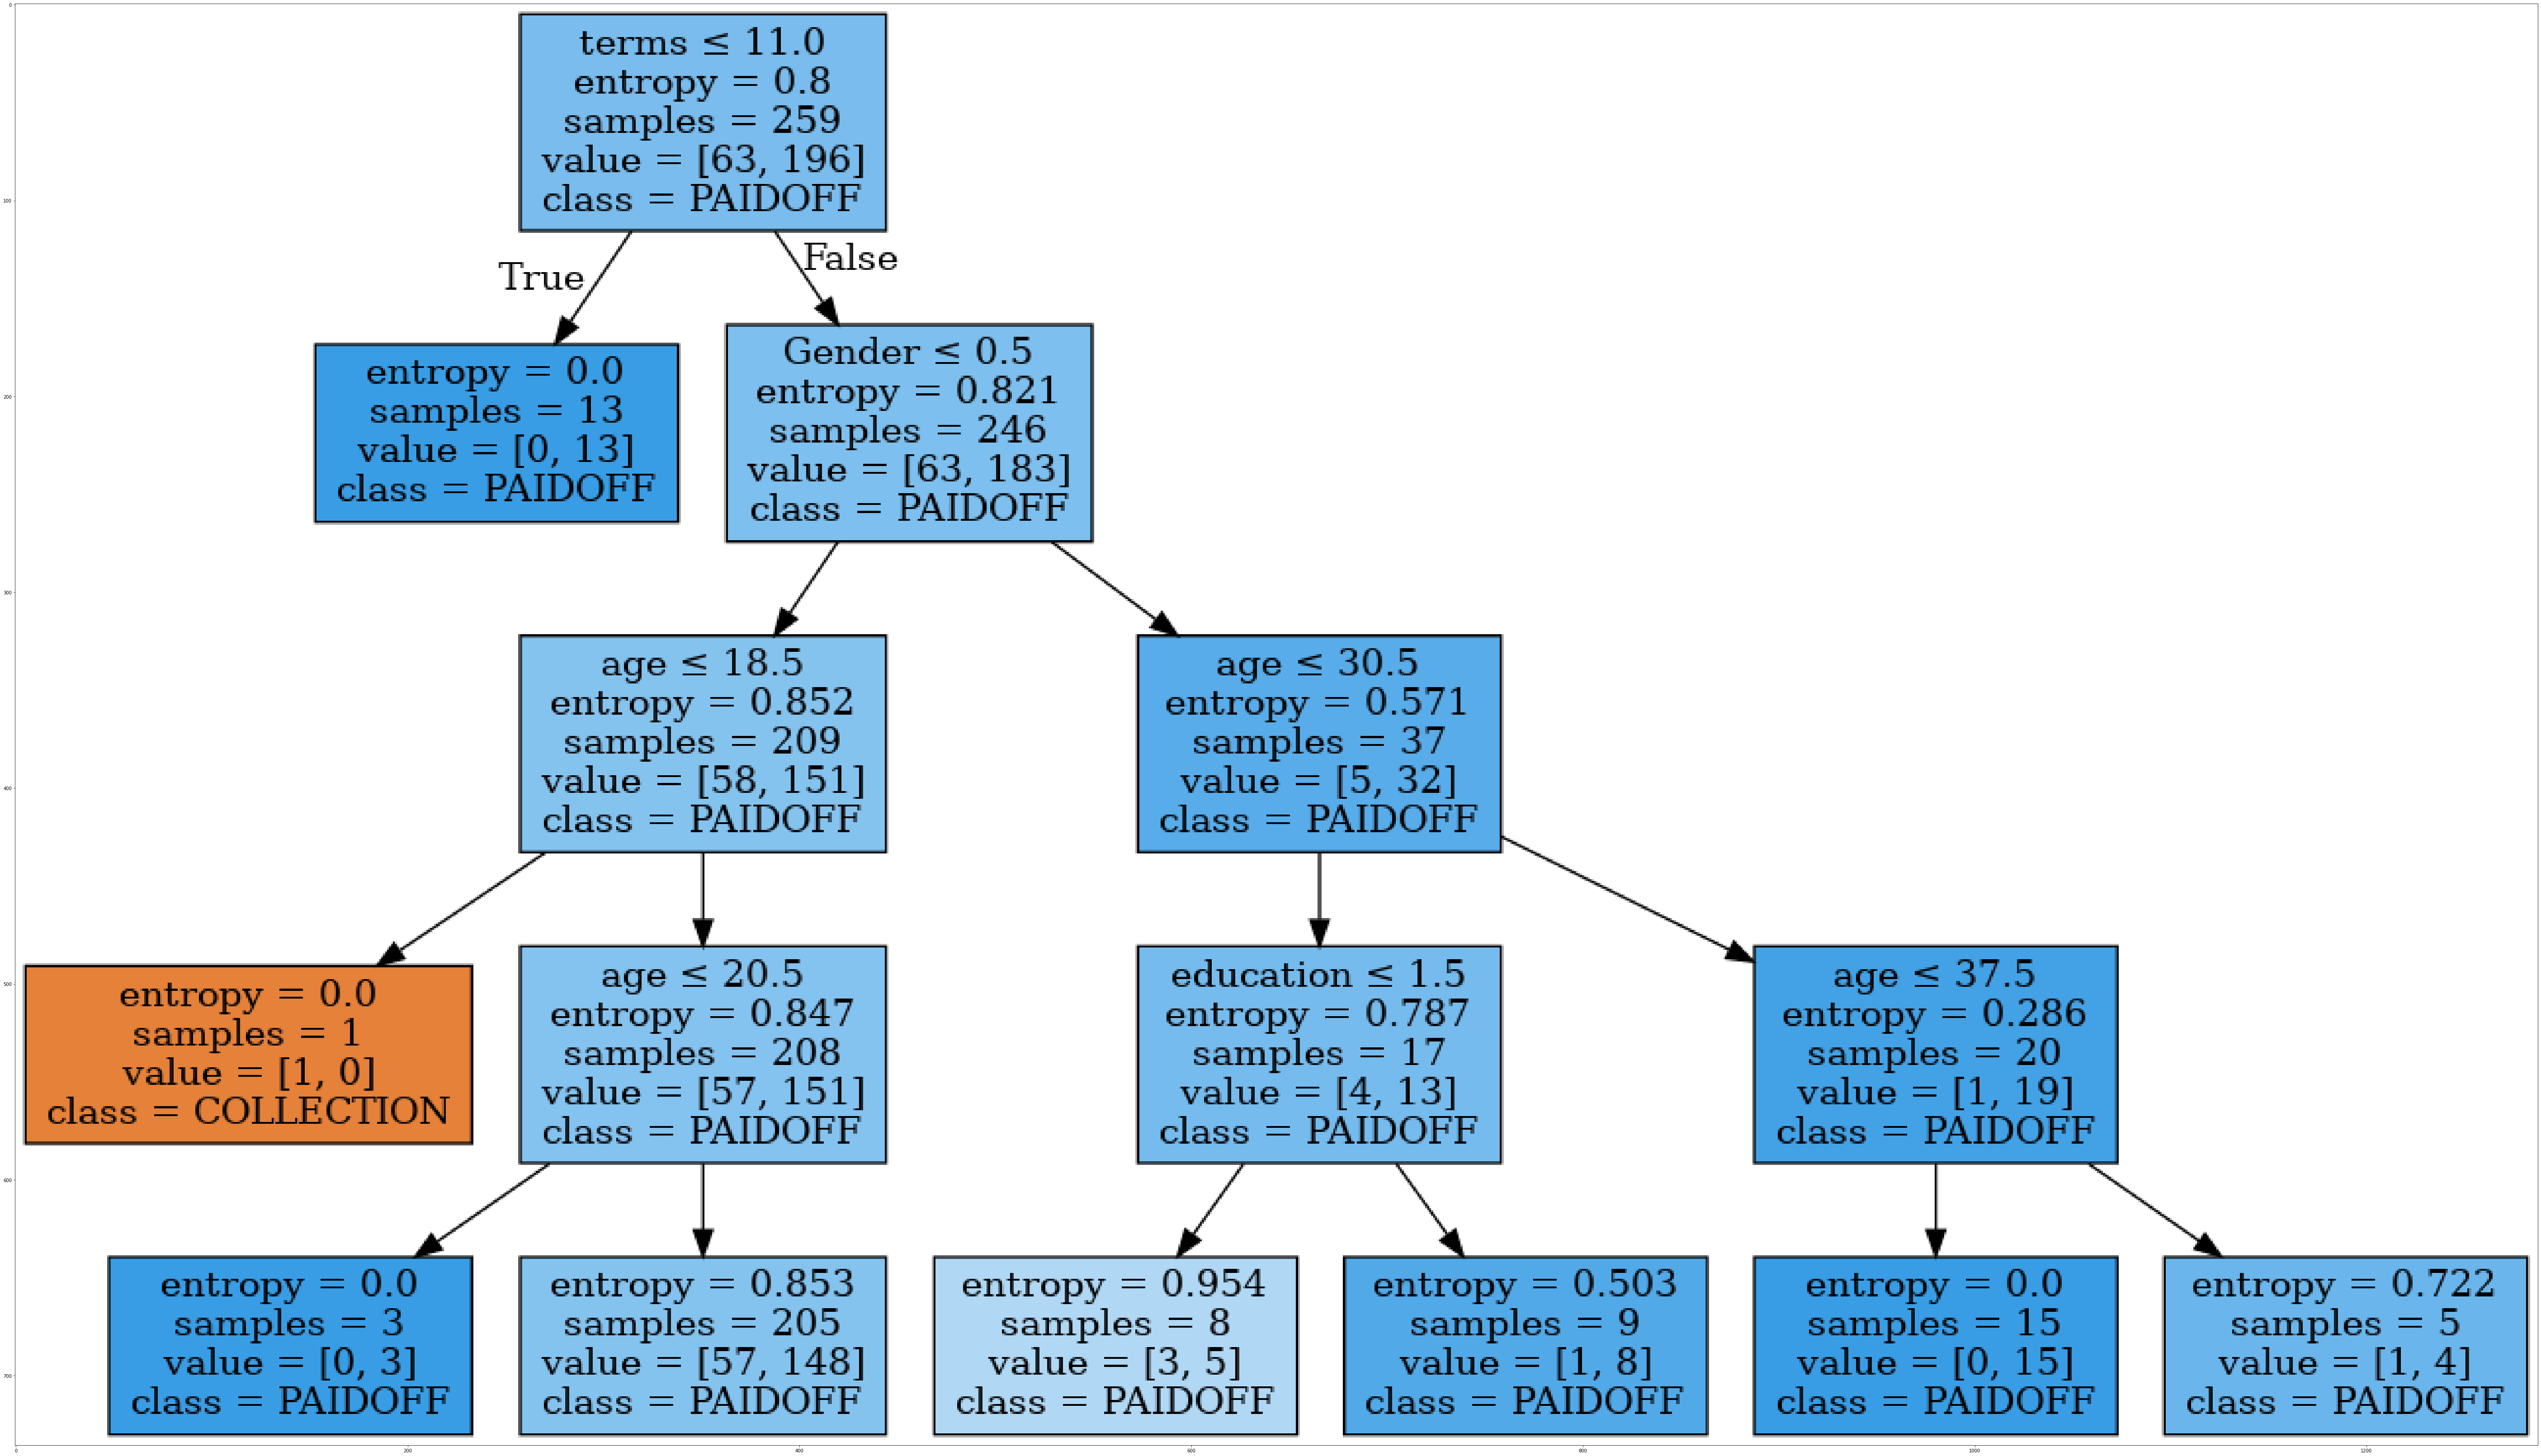

In [41]:
dot_data = StringIO()
filename = "loantree_MLS.png"
featureNames = df_DT.columns[0:5]
len(featureNames)
out=tree.export_graphviz(loanTree,feature_names=featureNames, out_file=dot_data, class_names= np.unique(y_train_DT),filled=True,special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Calculating Jaccard and F-1 scores  

In [42]:
predTree_bin=[]
y_test_DT_bin=[]

predTree_bin[:] = le_class.transform(predTree[:]) 
y_test_DT_bin[:] = le_class.transform(y_test_DT[:]) 

jac_DT=jaccard_score(y_test_DT_bin, predTree_bin, average='binary')


f1_DT=f1_score(y_test_DT_bin, predTree_bin, average='binary')

In [43]:
print("Jaccard score:", jac_DT, "F-1 score:", f1_DT)

Jaccard score: 0.735632183908046 F-1 score: 0.847682119205298


# Support Vector Machine


### Downloading and processing the data

In [44]:
df_SVM = pd.read_csv('loan_train.csv')
df_SVM.head()

df_SVM.drop(['Unnamed: 0.1'], axis = 1,inplace=True)
df_SVM.drop(['Unnamed: 0'], axis = 1,inplace=True)
df_SVM.drop(['effective_date'], axis = 1,inplace=True)
df_SVM.drop(['due_date'], axis = 1,inplace=True)

#df_SVM=df_SVM[['Principal', 'terms', 'age', 'education', 'Gender', 'loan_status']]
#df_DT.head()

df_SVM['education'].replace(to_replace=['High School or Below','Bechalor', 'Master or Above', 'college'], value=[0,1,2,3],inplace=True)
df_SVM['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df_SVM['loan_status'].replace(to_replace=['PAIDOFF','COLLECTION'], value=[0,1],inplace=True)

#print(df_SVM)
df_SVM.head()

,loan_status,Principal,terms,age,education,Gender
0,0,1000,30,45,0,0
1,0,1000,30,33,1,1
2,0,1000,15,27,3,0
3,0,1000,30,28,3,1
4,0,1000,30,29,3,0


### Visualization of loan status as a function of age and gender

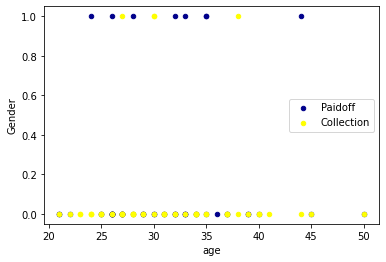

In [45]:
ax = df_SVM[df_SVM['loan_status'] == 0][0:50].plot(kind='scatter', x='age', y='Gender', color='DarkBlue', label='Paidoff');
df_SVM[df_SVM['loan_status'] == 1][0:50].plot(kind='scatter', x='age', y='Gender', color='Yellow', label='Collection', ax=ax);
plt.show()

### Defining x and y variables

In [46]:
X_SVM = df_SVM[['Principal', 'terms', 'age', 'education', 'Gender']].values

y_SVM = df_SVM["loan_status"].values

print(X_SVM[0:5], y_SVM[0:5])

[[1000   30   45    0    0]
 [1000   30   33    1    1]
 [1000   15   27    3    0]
 [1000   30   28    3    1]
 [1000   30   29    3    0]] [0 0 0 0 0]


### Splitting into train and test sets

In [47]:
X_train_SVM, X_test_SVM, y_train_SVM, y_test_SVM = train_test_split(X_SVM, y_SVM, test_size=0.25, random_state=4)
print ('Train set:', X_train_SVM.shape,  y_train_SVM.shape)
print ('Test set:', X_test_SVM.shape,  y_test_SVM.shape)

Train set: (259, 5) (259,)
Test set: (87, 5) (87,)


### Available functions to use in SVM
1.Linear \\\
2.Polynomial \\\
3.Radial basis function (RBF) \\\
4.Sigmoid

In [48]:
clf = svm.SVC(kernel='sigmoid')
clf.fit(X_train_SVM, y_train_SVM)

SVC(kernel='sigmoid')

In [49]:
y_test_SVM [0:259]

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0])

In [50]:
yhat_SVM = clf.predict(X_test_SVM)
yhat_SVM [0:87]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

### Definition and visualization of confusion matrix

In [51]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/marion/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.74      1.00      0.85        64
           1       0.00      0.00      0.00        23

    accuracy                           0.74        87
   macro avg       0.37      0.50      0.42        87
weighted avg       0.54      0.74      0.62        87

Confusion matrix, without normalization
[[64  0]
 [23  0]]


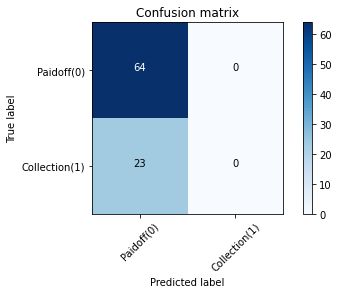

In [52]:
# Compute confusion matrix
cnf_matrix_SVM = confusion_matrix(y_test_SVM, yhat_SVM, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test_SVM, yhat_SVM))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_SVM, classes=['Paidoff(0)','Collection(1)'],normalize=False, title='Confusion matrix')

### Calculating Jaccard and F-1 scores

In [53]:
jac_SVM=jaccard_score(y_test_SVM, yhat_SVM, average='weighted')

f1_SVM=f1_score(y_test_SVM, yhat_SVM, average='weighted')

In [54]:
print("Jaccard score:", jac_SVM, "F-1 score:", f1_SVM)

Jaccard score: 0.5411547100013212 F-1 score: 0.6235822486107939


# Logistic Regression


In [55]:
df_LR=df_SVM[['Principal', 'terms', 'age', 'education', 'Gender','loan_status']]

df_LR.head()
#LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
#LR

,Principal,terms,age,education,Gender,loan_status
0,1000,30,45,0,0,0
1,1000,30,33,1,1,0
2,1000,15,27,3,0,0
3,1000,30,28,3,1,0
4,1000,30,29,3,0,0


### Normalizing the data

In [56]:
X_LR = df_LR[['Principal', 'terms', 'age', 'education', 'Gender']].values
X_LR = preprocessing.StandardScaler().fit(X_LR).transform(X_LR)


y_LR = df_LR["loan_status"].values

print(X_LR[0:5], y_LR[0:5])

[[ 0.52  0.92  2.33 -1.02 -0.42]
 [ 0.52  0.92  0.34 -0.31  2.38]
 [ 0.52 -0.96 -0.65  1.12 -0.42]
 [ 0.52  0.92 -0.49  1.12  2.38]
 [ 0.52  0.92 -0.32  1.12 -0.42]] [0 0 0 0 0]


### Splitting data into train and test sets

In [57]:
X_train_LR, X_test_LR, y_train_LR, y_test_LR = train_test_split(X_LR, y_LR, test_size=0.25, random_state=4)
print ('Train set:', X_train_LR.shape,  y_train_LR.shape)
print ('Test set:', X_test_LR.shape,  y_test_LR.shape)

Train set: (259, 5) (259,)
Test set: (87, 5) (87,)


### Modeling logistic regression

In [58]:
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train_LR,y_train_LR)
LR

LogisticRegression(C=0.01, solver='liblinear')

### Training the set

In [59]:
yhat_LR = LR.predict(X_test_LR)
yhat_LR

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [60]:
yhat_prob_LR = LR.predict_proba(X_test_LR)
yhat_prob_LR[0:5]

array([[0.57, 0.43],
       [0.62, 0.38],
       [0.61, 0.39],
       [0.56, 0.44],
       [0.58, 0.42]])

### Calculating Jaccard, LogLoss and J-1 scores

In [61]:
jac_LR=jaccard_score(y_test_LR, yhat_LR,pos_label=0)
ll_LR=log_loss(y_test_LR, yhat_prob_LR)
f1_LR=f1_score(y_test_LR, yhat_LR, average='weighted')

In [62]:
print("Jaccard score:", jac_LR, "F-1 score:", f1_LR, "LogLoss:", ll_LR)

Jaccard score: 0.735632183908046 F-1 score: 0.6235822486107939 LogLoss: 0.6145844710369777


# Report

You should be able to report the accuracy of the built model using different evaluation metrics:


| Algorithm          | Jaccard | F1-score | LogLoss |
| ------------------ | ------- | -------- | ------- |
| KNN                | 0.765   | 0.867    | NA      |
| Decision Tree      | 0.735   | 0.847    | NA      |
| SVM                | 0.541   | 0.623    | NA      |
| LogisticRegression | 0.735   | 0.623    | 0.614   |


<h2>Want to learn more?</h2>

IBM SPSS Modeler is a comprehensive analytics platform that has many machine learning algorithms. It has been designed to bring predictive intelligence to decisions made by individuals, by groups, by systems – by your enterprise as a whole. A free trial is available through this course, available here: <a href="http://cocl.us/ML0101EN-SPSSModeler?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">SPSS Modeler</a>

Also, you can use Watson Studio to run these notebooks faster with bigger datasets. Watson Studio is IBM's leading cloud solution for data scientists, built by data scientists. With Jupyter notebooks, RStudio, Apache Spark and popular libraries pre-packaged in the cloud, Watson Studio enables data scientists to collaborate on their projects without having to install anything. Join the fast-growing community of Watson Studio users today with a free account at <a href="https://cocl.us/ML0101EN_DSX?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Watson Studio</a>

<h3>Thanks for completing this lesson!</h3>

<h4>Author:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDeveloperSkillsNetworkML0101ENSkillsNetwork20718538-2021-01-01">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD is a Data Scientist in IBM with a track record of developing enterprise level applications that substantially increases clients’ ability to turn data into actionable knowledge. He is a researcher in data mining field and expert in developing advanced analytic methods like machine learning and statistical modelling on large datasets.</p>

<hr>

## Change Log

| Date (YYYY-MM-DD) | Version | Changed By    | Change Description                                                             |
| ----------------- | ------- | ------------- | ------------------------------------------------------------------------------ |
| 2020-10-27        | 2.1     | Lakshmi Holla | Made changes in import statement due to updates in version of  sklearn library |
| 2020-08-27        | 2.0     | Malika Singla | Added lab to GitLab                                                            |

<hr>

## <h3 align="center"> © IBM Corporation 2020. All rights reserved. <h3/>

<p>
